In [4]:
import pyspark as ps
spark = ps.sql.SparkSession.builder.master("local").appName("ElbowMethodTest").getOrCreate()

In [5]:
df = spark.read.csv("data/filtered_clean.csv", header=True, inferSchema=True)
df.show(5)

+--------------------+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+-------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+----------------+--------------------+-------------+--------------------+-------------+--------------+--------------+--------------+
|                 _id|app_id|                name|type|required_age|is_free| supported_languages|          developers|          publishers|price_final|platforms_windows|platforms_mac|platforms_linux|          categories|              genres|recommen

In [6]:
from pyspark.sql.functions import regexp_replace, when, col, array_contains, split, explode

In [7]:
# Step 1: Create a temporary column for cleaned categories
df = df.withColumn("categories_clean", regexp_replace("categories", "\\[|\\]|'", ""))
df = df.withColumn("categories_list", split(col("categories_clean"), ", "))

# Step 2: Explode categories
exploded = df.select("app_id", explode(col("categories_list")).alias("category"))

# Step 3: Get distinct categories and clean them
distinct_categories = (
    exploded.select("category")
    .distinct()
    .toPandas()["category"]
    .str.replace(" ", "_")
    .tolist()
)

# Step 4: Create binary columns with cat_ prefix
for cat in distinct_categories:
    df = df.withColumn(f"category_{cat}", when(array_contains(col("categories_list"), cat), 1).otherwise(0))

# Step 5: Drop temporary columns
df = df.drop("categories_clean", "categories_list", "category__Swahili", "category_False", "category__Latvian", "category__Maltese", "category__Luxembourgish","")

df.show()

+--------------------+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+-----

In [8]:
# Step 1: Create temporary columns for cleaned genres
df = df.withColumn("genres_clean", regexp_replace("genres", "\\[|\\]|'", ""))
df = df.withColumn("genres_list", split(col("genres_clean"), ", "))

# Step 2: Explode genres
exploded_genres = df.select("app_id", explode(col("genres_list")).alias("genre"))

# Step 3: Get distinct genres and clean them
distinct_genres = (
    exploded_genres.select("genre")
    .distinct()
    .toPandas()["genre"]
    .str.replace(" ", "_")
    .tolist()
)

# Step 4: Create binary columns with genre_ prefix
for genre in distinct_genres:
    df = df.withColumn(f"genre_{genre}", when(array_contains(col("genres_list"), genre), 1).otherwise(0))

# Step 5: Drop temporary columns
df = df.drop("genres_clean", "genres_list", "genre_Maori", "genre_false", "genre__Macedonian", "genre__Serbian", "genre_", "genre__Lithuanian")

df.show()

+--------------------+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+-----

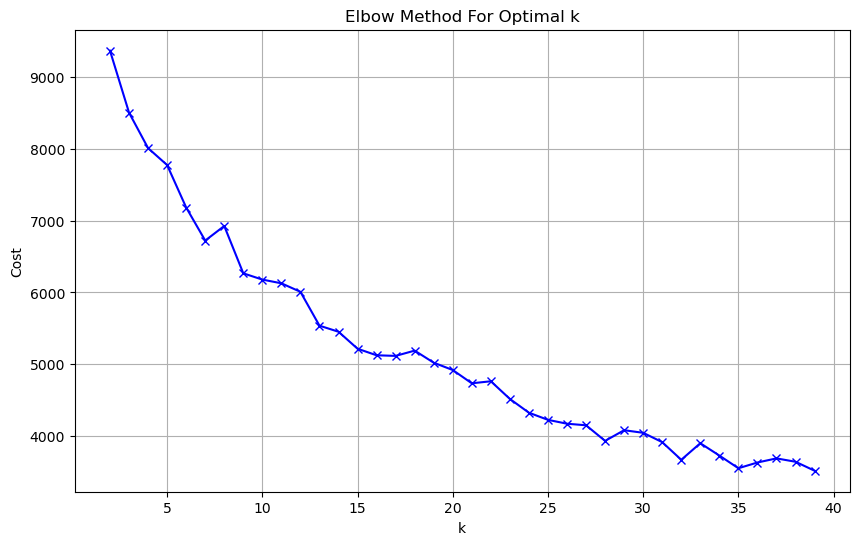

k: 2, Cost: 9362.611183471226
k: 3, Cost: 8500.95636548161
k: 4, Cost: 8007.599332800019
k: 5, Cost: 7772.116463717559
k: 6, Cost: 7181.932608712132
k: 7, Cost: 6721.952866006885
k: 8, Cost: 6925.0092461171635
k: 9, Cost: 6266.32600039013
k: 10, Cost: 6179.415265218578
k: 11, Cost: 6127.590531168937
k: 12, Cost: 6009.253101841974
k: 13, Cost: 5538.255946155904
k: 14, Cost: 5453.841156316011
k: 15, Cost: 5217.640226991549
k: 16, Cost: 5126.5493073924845
k: 17, Cost: 5118.0376036839325
k: 18, Cost: 5191.254388546183
k: 19, Cost: 5023.36965361702
k: 20, Cost: 4921.331612494117
k: 21, Cost: 4736.74478652878
k: 22, Cost: 4765.012251955837
k: 23, Cost: 4519.159484098379
k: 24, Cost: 4327.498700068205
k: 25, Cost: 4228.3504678854815
k: 26, Cost: 4174.620322440885
k: 27, Cost: 4152.755510813002
k: 28, Cost: 3936.061802680295
k: 29, Cost: 4084.217461568999
k: 30, Cost: 4048.037667698859
k: 31, Cost: 3918.170740264828
k: 32, Cost: 3673.0051252663375
k: 33, Cost: 3903.1408222808664
k: 34, Cost: 3

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create list of input columns
category_cols = [col for col in df.columns if col.startswith('category_')]
genre_cols = [col for col in df.columns if col.startswith('genre_')]
feature_cols = category_cols + genre_cols

# Fill null values with 0
df_clean = df.fillna(0, subset=feature_cols)

# Create VectorAssembler with handleInvalid="skip"
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"  # Skip invalid entries
)

# Transform the data
vector_df = assembler.transform(df_clean)

# Calculate cost for different k values
cost = []
K = range(2, 40)  # Test k from 2 to 20

for k in K:
    kmeans = KMeans(k=k, seed=42)
    model = kmeans.fit(vector_df.select('features'))
    cost.append(model.summary.trainingCost)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Print the costs
for k, c in zip(K, cost):
    print(f'k: {k}, Cost: {c}')

In [10]:
# Once you've chosen the optimal k, train the final model
optimal_k = 15  # Replace with your chosen optimal k
final_kmeans = KMeans(k=optimal_k, seed=42)
final_model = final_kmeans.fit(vector_df)

# Get cluster assignments
predictions = final_model.transform(vector_df)

# Evaluate the clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Get cluster centers
centers = final_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    rounded_center = [round(attr, 3) for attr in center]
    print(rounded_center)

Silhouette with squared euclidean distance = 0.28273557722553666
Cluster Centers: 
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.01), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.004), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.003), np.float64(0.0), np.float64(0.0), np.float64

In [11]:
# Add a 'cluster' column to the DataFrame with the cluster assignments
df_with_clusters = predictions.withColumn("cluster", col("prediction"))

# Show the DataFrame with the new 'cluster' column
df_with_clusters.show()

+--------------------+------+--------------------+----+------------+-------+--------------------+--------------------+--------------------+-----------+-----------------+-------------+---------------+--------------------+--------------------+---------------------+------------+--------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------+-----------------------------------+----------------------------+--------------------------+-----------------------+--------------------+-----------------------------+-------------------------+-----

In [19]:
# Drop the features and prediction columns first
df_with_clusters = df_with_clusters.drop('features', 'prediction')

# Then proceed with the rest of the cleaning
columns_to_keep = [
    "_id",
    "app_id",
    "name",
    "type",
    "required_age",
    "is_free",
    "supported_languages",
    "developers",
    "publishers",
    "price_final",
    "platforms_windows",
    "platforms_mac",
    "platforms_linux",
    "categories",
    "genres",
    "recommendations_total",
    "release_date",
    "price_currency",
    "metacritic_score",
    "short_description",
    "detailed_description",
    "about_the_game",
    "website",
    "discount_percent",
    "pc_min_os",
    "pc_min_processor",
    "pc_min_memory",
    "pc_min_graphics",
    "pc_min_directx",
    "pc_min_network",
    "pc_min_storage",
    "header_image",
    "background",
    "screenshots_count",
    "movies_count",
    "pc_rec_os",
    "pc_rec_processor",
    "pc_rec_memory",
    "pc_rec_graphics",
    "support_email",
    "pc_rec_directx",
    "pc_rec_network",
    "pc_rec_storage",
    "cluster"  # Keep the cluster column
]

# Drop all columns that start with 'category_' or 'genre_'
columns_to_drop = [col_name for col_name in df_with_clusters.columns 
                  if col_name.startswith(('category_', 'genre_')) 
                  and col_name not in columns_to_keep]

# Create cleaned DataFrame
cleaned_df = df_with_clusters.drop(*columns_to_drop)

# Convert to pandas DataFrame
pandas_df = cleaned_df.toPandas()

# Save as pickle file (most efficient for pandas)
pandas_df.to_pickle("data/cleaned_clustered_data.pkl")

print("Data cleaning completed. Data saved to 'data/cleaned_clustered_data.pkl'")

Data cleaning completed. Data saved to 'data/cleaned_clustered_data.pkl'
